Generate iteration speed figure for JOSS paper. Iteration times come from https://becksteinlab.github.io/zarrtraj/#/

While these results come from using the automated benchmarking system [airspeed velocity](https://github.com/airspeed-velocity/asv) (see 'benchmarks/reader_bms.py' for the code), below in section 2 we describe how to perform the same analyses without ASV


## 1. ASV benchmark figure


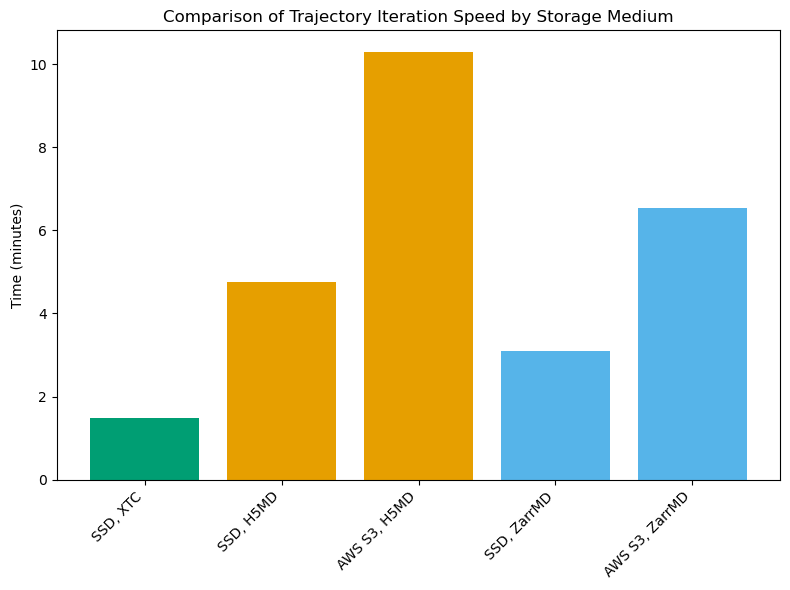

In [8]:
import matplotlib.pyplot as plt


labels = ['SSD, XTC', 'SSD, H5MD',  'AWS S3, H5MD', 'SSD, ZarrMD', 'AWS S3, ZarrMD']
values = [1.49, 4.76, 10.30,3.10, 6.53]  
colors = ['#009e73', '#e69f00', '#e69f00','#56b4e9', '#56b4e9']

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=colors)


plt.title('Comparison of Trajectory Iteration Speed by Storage Medium')
plt.ylabel('Time (minutes)')


plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('benchmark.png')
plt.show()

## 2. Performing the stride benchmark in jupyter

Prerequisites:

- Create a python environment with `zarrtraj` installed (see [installation](https://zarrtraj.readthedocs.io/en/latest/installation.html#installation))
- Install `ipykernel` to be able to run jupyter notebooks
- Install `matplotlib` for plotting
- Install `MDAnalysisData` for the sample topology and trajectory data
- Install `dask` for the parallelized analysis benchmark
- Install `boto3` only if you are reproducing the H5MD from S3 part of the benchmark


### 1. Download PDB topology and (un-aligned) XTC trajectory using MDAnalysisData


In [ ]:
import MDAnalysisData

dataset = MDAnalysisData.yiip_equilibrium.fetch_yiip_equilibrium_long(data_home="../zarrtraj/data")

### 2. Align and write trajectory files in different formats

Write to disk:

- H5MD on disk
- ZarrMD on disk
- XTC on disk

These scripts are meant to be run from root of the cloned zarrtraj repository, from the python environment described above:

```python
# this script must be run first, since the other two rely on the XTC aligned traj
python zarrtraj/data/write_aligned_yiip_xtc.py
python zarrtraj/data/write_aligned_uncompressed_disk_h5md.py
python zarrtraj/data/write_aligned_uncompressed_disk_zarrmd.py
```


Additionally, write to cloud:

- H5MD on S3
- ZarrMD on S3

The bucket URL used by these scripts is not publicly readable or writeable due to cost, but follow [the guide on writing to cloud storage](https://zarrtraj.readthedocs.io/en/latest/walkthrough.html#writing-trajectories-to-cloud-storage) if you're interested in reproducing this part of the benchmark with your own bucket.

```python
python zarrtraj/data/write_aligned_uncompressed_s3_zarrmd.py
# since zarrtraj doesn't allow writing H5MD files directly to cloud buckets, below script uploads the trajectory created by "write_aliged_compressed_disk_h5md.py"
python zarrtraj/data/write_aligned_uncompressed_s3_h5md.py
```


### 3. Benchmark method


In [ ]:
from MDAnalysis.analysis.rms import RMSD
import time

def time_stride(reader_object):
    start = time.time()
    for ts in reader_object:
        pass
    stop = time.time()

    return stop - start

### 4. Load disk data and run disk benchmarks


In [ ]:
import MDAnalysis as mda
import zarrtraj

TOPOL = "../zarrtraj/data/yiip_equilibrium/YiiP_system.pdb"
H5MD_DISK_TRAJ = "../zarrtraj/data/yiip_aligned_uncompressed.h5md"
ZARRMD_TRAJ_DISK = "../zarrtraj/data/yiip_aligned_uncompressed.zarrmd"
XTC_TRAJ = "../zarrtraj/data/yiip_equilibrium/YiiP_system_90ns_center_aligned.xtc"

xtc_u = mda.Universe(TOPOL, XTC_TRAJ)
h5md_disk_u = mda.Universe(TOPOL, H5MD_DISK_TRAJ)
zarrmd_disk_u = mda.Universe(TOPOL, ZARRMD_TRAJ_DISK)

In [ ]:
xtc_stride_time = time_stride(xtc_u.trajectory)
print(f"XTC stride time: {xtc_stride_time:.2f} seconds")
h5md_disk_stride_time = time_stride(h5md_disk_u.trajectory)
print(f"H5MD on disk stride time: {h5md_disk_stride_time:.2f} seconds")
zarrmd_disk_stride_time = time_stride(zarrmd_disk_u.trajectory)
print(f"ZarrMD on disk stride time: {zarrmd_disk_stride_time:.2f} seconds")

### 5. Load S3 data and run cloud benchmarks


In [ ]:
import os
import MDAnalysis as mda
import zarrtraj

os.environ["S3_REGION_NAME"] = "us-west-1"
os.environ["AWS_PROFILE"] = "sample_profile"

TOPOL = "../zarrtraj/data/yiip_equilibrium/YiiP_system.pdb"
H5MD_S3_TRAJ = "s3://zarrtraj-test-data/yiip_aligned_uncompressed.h5md"
ZARRMD_TRAJ_S3 = "s3://zarrtraj-test-data/yiip_aligned_uncompressed.zarrmd"

h5md_s3_u = mda.Universe(TOPOL, H5MD_S3_TRAJ)
zarrmd_s3_u = mda.Universe(TOPOL, ZARRMD_TRAJ_S3)

In [ ]:
h5md_s3_stride_time = time_stride(h5md_s3_u.trajectory)
print(f"H5MD on S3 stride time: {h5md_s3_stride_time:.2f} seconds")
zarrmd_s3_stride_time = time_stride(zarrmd_s3_u.trajectory)
print(f"ZarrMD on S3 stride time: {zarrmd_s3_stride_time:.2f} seconds")